In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
import numpy as np
import os

from model import Layer, LAYER_TYPE_BOTTOM, LAYER_TYPE_HIDDEN, LAYER_TYPE_TOP, LowPassFilter
from option import Option

In [8]:
class Network(object):
    def __init__(self):
        option = Option()

        self.layers = [None] * 3
        self.layers[0] = Layer(pd_unit_size=30, layer_type=LAYER_TYPE_BOTTOM, option=option)
        self.layers[1] = Layer(pd_unit_size=20, layer_type=LAYER_TYPE_HIDDEN, option=option)
        self.layers[2] = Layer(pd_unit_size=10, layer_type=LAYER_TYPE_TOP,    option=option)
        
        self.layers[0].connect_to(self.layers[1])
        self.layers[1].connect_to(self.layers[2])

        self.set_self_prediction_mode()

    def set_self_prediction_mode(self):
        # Pyramidalのweightは更新しない
        for layer in self.layers:
            layer.train_w_pp_bu = False
            layer.train_w_pp_td = False
            layer.train_w_ip = True
            layer.train_w_pi = True

        for i,layer in enumerate(self.layers):
            option = Option.get_self_prediction_option(i)
            layer.set_option(option)

    def set_target_prediction_mode(self):
        # Pyramidalのweightを更新する
        for layer in self.layers:
            layer.train_w_pp_bu = True
            layer.train_w_pp_td = False # TopDownのWeightは固定
            layer.train_w_ip = True
            layer.train_w_pi = True

        for i,layer in enumerate(self.layers):
            option = Option.get_target_prediction_option(i)
            layer.set_option(option)

    def update(self, dt):
        for layer in self.layers:
            layer.update_potential(dt)

        for layer in self.layers:
            layer.update_weight(dt)

    def set_input_firing_rate(self, values):
        self.layers[0].set_input_firing_rate(values)

    def set_target_firing_rate(self, values):
        self.layers[2].set_target_firing_rate(values)

    def clear_target(self):
        self.layers[2].clear_target()

    def save(self, dir_name):
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)

        for i in range(2):
            # Top層はSaveするものが無いので対象外
            file_path = os.path.join(dir_name, "layer{}".format(i))
            self.layers[i].save(file_path)

        print("saved: {}".format(dir_name))

    def load(self, dir_name):
        for i in range(2):
            # Top層はLoadするものが無いので対象外
            file_path = os.path.join(dir_name, "layer{}".format(i))
            self.layers[i].load(file_path)

        print("loaded: {}".format(dir_name))

In [10]:
network = Network()
network.load("saved")

weight loaded: saved/layer0.npz
weight loaded: saved/layer1.npz
loaded: saved


In [12]:
network.set_target_prediction_mode()
    
dt = 0.1
lp_filter = LowPassFilter(dt, 3)

target_values = np.random.rand(10)
values = np.random.rand(30)

erros = []
u_targets = []
u_ps = []

for i in range(100):
    for j in range(1000):
        filtered_values = lp_filter.process(values)
        network.set_target_firing_rate(target_values)
        network.set_input_firing_rate(filtered_values)
        network.update(dt)
            
        error = np.mean(network.layers[1].v_p_a)
        u_target = network.layers[2].u_target[1]
        u_p          = network.layers[2].u_p[1]
        
        erros.append(error)
        u_targets.append(u_target)
        u_ps.append(u_p)

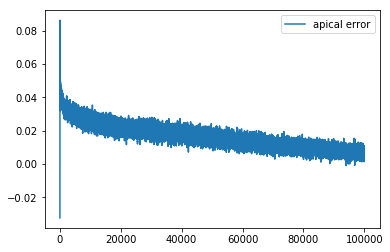

In [22]:
plt.plot(erros, label="apical error")
plt.legend()
plt.show()

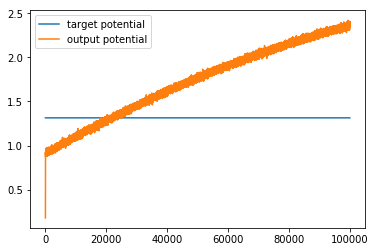

In [21]:
plt.plot(u_targets, label="target potential")
plt.plot(u_ps, label="output potential")
plt.legend()
plt.show()